<a href="https://colab.research.google.com/github/shuvad23/image-classification-projects/blob/main/Fashion_MNIST_ANN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fashion-MNIST ANN classifier


- Project Title

    - Fashion-MNIST Image Classification using Artificial Neural Network (ANN)

- Project Overview

    - This project builds an Artificial Neural Network (ANN) to classify clothing images from the Fashion-MNIST dataset using PyTorch.
    - The task is a multi-class classification problem with 10 fashion categories

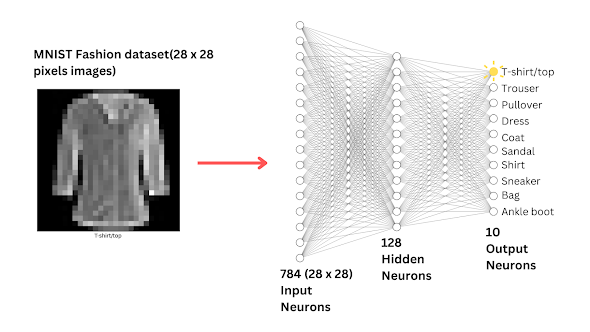

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


In [4]:
#Hyperparameters
INPUT_SIZE = 28*28 # 784 Pixels
HIDDEN_SIZE_1 = 512
HIDDEN_SIZE_2 = 256
HIDDEN_SIZE_3 = 128
NUM_CLASSES =  10
NUM_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [5]:
# Fashion-MNIST class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# Define the ANN model
class Fashion_ANN(nn.Module):
    def __init__(self,input_size, hidden_layer_1,hidden_layer_2,hidden_layer_3,num_classes):
        super(Fashion_ANN,self).__init__()

        self.fc1 = nn.Linear(input_size,hidden_layer_1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(hidden_layer_2,hidden_layer_3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(hidden_layer_3,num_classes)
    def forward(self,x):
        x = x.view(x.size(0), -1) # Flatten the image
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.dropout3(self.relu3(self.fc3(x)))
        x = self.fc4(x)
        return x


In [7]:
# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5)) # Normalize to [-1, 1]
])

In [8]:
# load datasets
train_dataset = datasets.FashionMNIST(root = './data', train = True, transform=transform,download=True)
test_dataset = datasets.FashionMNIST(root = './data', train = False, transform=transform,download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.5MB/s]


In [9]:
# train_loader and test_loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,shuffle=False)
print(f"Training Samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training Samples: 60000
Test samples: 10000


In [10]:
# Initialize model, loss, and optimizer
model = Fashion_ANN(INPUT_SIZE,HIDDEN_SIZE_1,HIDDEN_SIZE_2,HIDDEN_SIZE_3,NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

print(f"\nModel Architecture; \n{model}")
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters())}")



Model Architecture; 
Fashion_ANN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

Total Parameters: 567434


In [11]:
# Training function
def train_epoch(model,loader,criterion,optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update step

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct +=(predicted == labels).sum().item()

    epoch_loss = running_loss/len(loader)
    epoch_acc = 100 * correct/total
    return epoch_loss, epoch_acc

In [15]:
# Evaluation function
def evaluate(model,loader,criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss/len(loader)
    epoch_acc = 100*correct/total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [16]:
# Training loop
print('\nStarting Training...\n')
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Starting Training...

Epoch [1/15]
  Train Loss: 0.3828, Train Acc: 86.01%
  Test Loss: 0.3752, Test Acc: 86.05%
Epoch [2/15]
  Train Loss: 0.3586, Train Acc: 87.04%
  Test Loss: 0.3636, Test Acc: 86.74%
Epoch [3/15]
  Train Loss: 0.3411, Train Acc: 87.60%
  Test Loss: 0.3558, Test Acc: 87.25%
Epoch [4/15]
  Train Loss: 0.3288, Train Acc: 88.08%
  Test Loss: 0.3548, Test Acc: 87.38%
Epoch [5/15]
  Train Loss: 0.3183, Train Acc: 88.36%
  Test Loss: 0.3379, Test Acc: 88.07%
Epoch [6/15]
  Train Loss: 0.3062, Train Acc: 88.68%
  Test Loss: 0.3378, Test Acc: 87.86%
Epoch [7/15]
  Train Loss: 0.2997, Train Acc: 89.08%
  Test Loss: 0.3452, Test Acc: 87.57%
Epoch [8/15]
  Train Loss: 0.2915, Train Acc: 89.33%
  Test Loss: 0.3501, Test Acc: 87.77%
Epoch [9/15]
  Train Loss: 0.2833, Train Acc: 89.56%
  Test Loss: 0.3387, Test Acc: 88.12%
Epoch [10/15]
  Train Loss: 0.2753, Train Acc: 89.85%
  Test Loss: 0.3388, Test Acc: 88.17%
Epoch [11/15]
  Train Loss: 0.2728, Train Acc: 89.90%
  Test Loss:

In [17]:
# Final evaluation
print('\nFinal Evaluation...')
_, final_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f'Final Test Accuracy: {final_acc:.2f}%')



Final Evaluation...
Final Test Accuracy: 88.79%


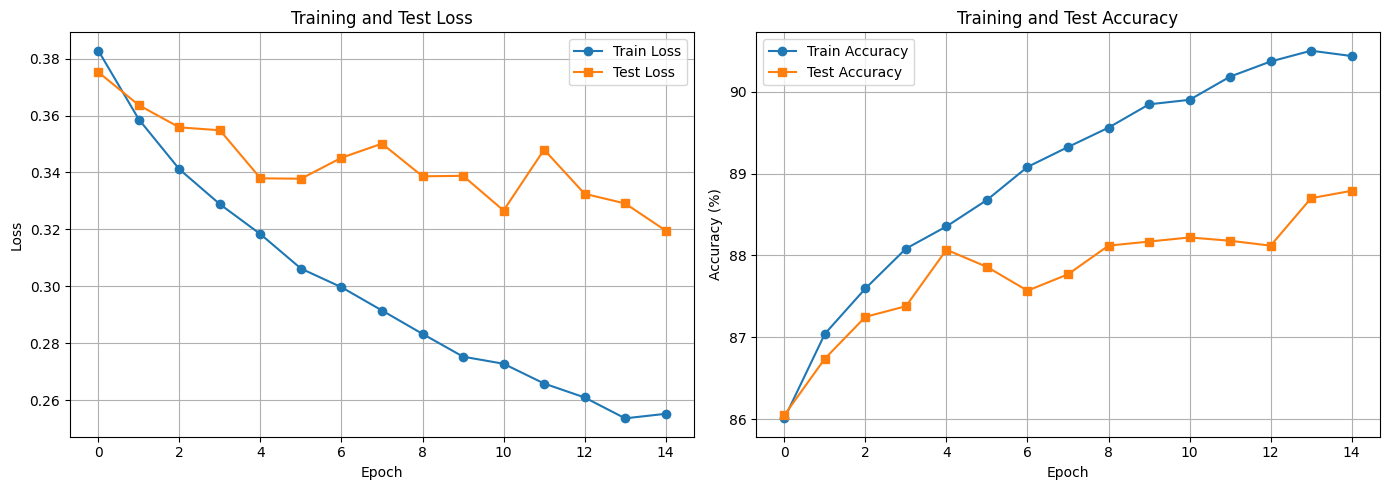

In [21]:
# Plotting results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(test_losses, label='Test Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(test_accs, label='Test Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

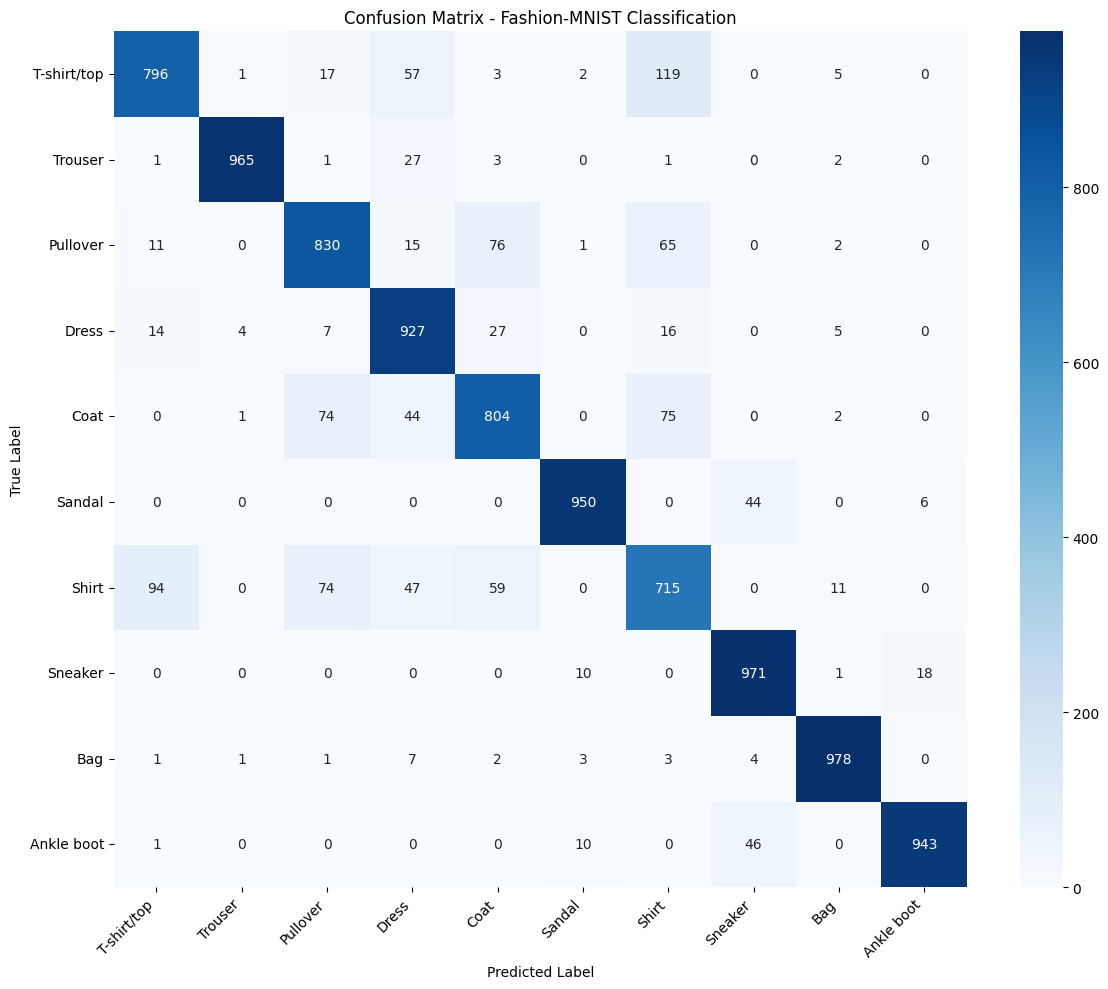

In [22]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Fashion-MNIST Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()




In [23]:
# Classification Report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))





Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.80      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.83      0.83      0.83      1000
       Dress       0.82      0.93      0.87      1000
        Coat       0.83      0.80      0.81      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.72      0.71      0.72      1000
     Sneaker       0.91      0.97      0.94      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



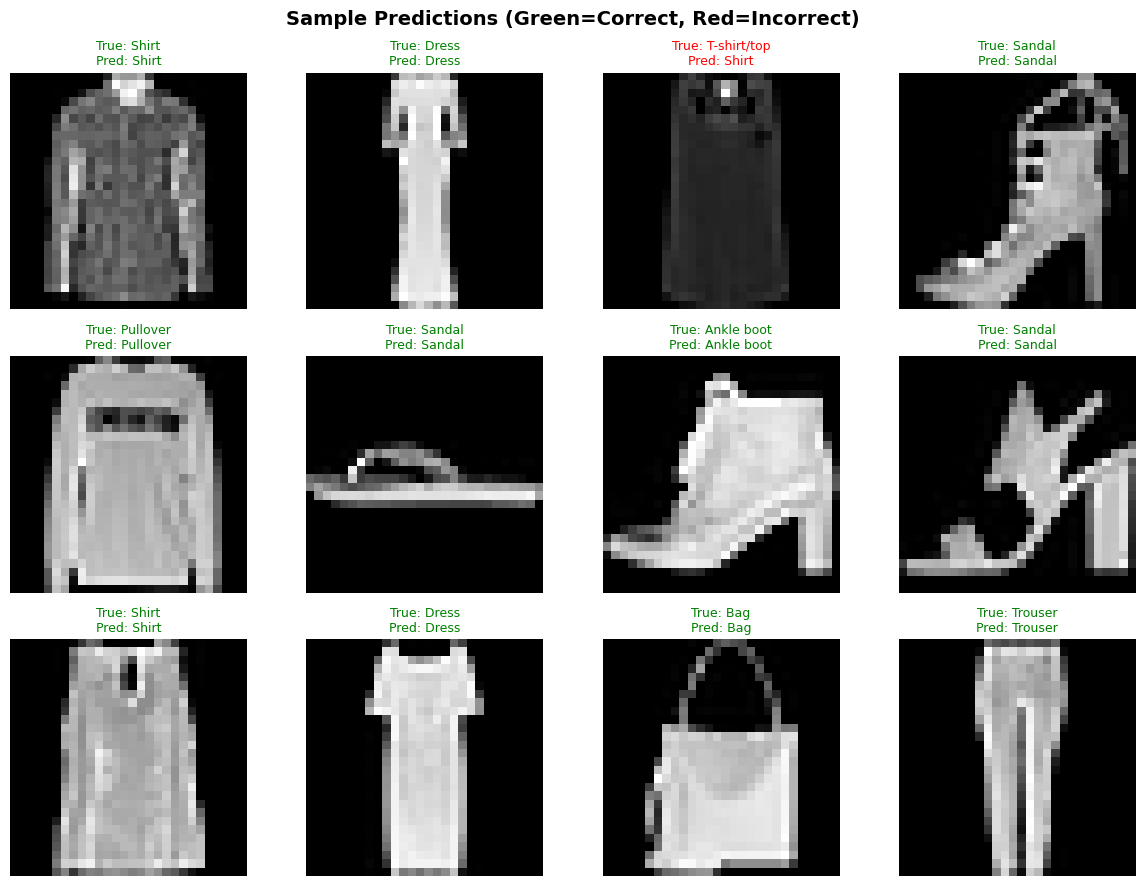


Model saved as fashion_mnist_ann.pth

=== Training Complete ===


In [24]:
# Visualize sample predictions
def plot_predictions(model, dataset, device, num_samples=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)

            # Display image
            img = image.squeeze().numpy()
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')

            # Add title with prediction
            pred_label = predicted.item()
            color = 'green' if pred_label == true_label else 'red'
            axes[i].set_title(f'True: {class_names[true_label]}\n'
                            f'Pred: {class_names[pred_label]}',
                            color=color, fontsize=9)

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_predictions(model, test_dataset, device)


# Save the model
torch.save(model.state_dict(), 'fashion_mnist_ann.pth')
print('\nModel saved as fashion_mnist_ann.pth')

print('\n=== Training Complete ===')